# Домашнее задание 1
## Harry Potter and the Action Prediction Challenge from Natural Language


В этом домашнем задании вы будете работать с корпусом Harry Potter and the Action Prediction Challenge. Корпус собран из фанфиков о Гарри Поттере и состоит из двух частей: 1) сырые тексты, 2) фрагменты текстов, описывающих ситуацию, в которой произнесено заклинание.

Корпус описан в статье: https://arxiv.org/pdf/1905.11037.pdf

David Vilares and Carlos Gómez-Rodríguez. Harry Potter and the Action Prediction Challenge from Natural Language. 2019 Annual Conference of the North American Chapter of the Association for Computational Linguistics. To appear.

Код для сбора корпуса находится в репозитории: https://github.com/aghie/hpac . Корпус можно скачать по инструкции из этого репозитория, но для экономии времени авторы задания уже скачали и подготовили данные к работе.

Ссылки на собранный корпус:
* Сырые тексты:  https://www.dropbox.com/s/12toaj67fjrguhd/hpac_raw.zip?dl=0
* Токенизированные тексты в нижнем регистре: https://www.dropbox.com/s/1ndto6dce5wg7j2/hpac_lower_tokenized.zip?dl=0
* train-test-dev: https://www.dropbox.com/s/ftinwwjfyydevth/hpac_splits.zip?dl=0

Части 1, 2 задания должны быть выполнены на полных текстах (сырых или предобработанных -- на ваше усмотрение), Часть 3 – на разбиение на тестовое, отладочное и обучающее множества. Тестовое множество должно быть использовано исключительно для тестирования моделей, обучающее и отладочное – для выбора модели и параметров.

В статье и репозитории вы найдете идеи, которые помогут вам выполнить домашнее задание. Их стоит воспринимать как руководство к действию, и не стоит их копировать и переиспользовать. Обученные модели использовать не нужно, код для их обучения можно использовать как подсказку.

In [ ]:
!unzip hpac_lower_tokenized

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: hpac_source/4615642     
  inflating: hpac_source/7028138     
  inflating: hpac_source/7525139     
  inflating: hpac_source/5172600     
  inflating: hpac_source/3857376     
  inflating: hpac_source/5349382     
  inflating: hpac_source/4716141     
  inflating: hpac_source/2527816     
  inflating: hpac_source/9002674     
  inflating: hpac_source/12377877    
  inflating: hpac_source/4482433     
  inflating: hpac_source/12561875    
  inflating: hpac_source/3958842     
  inflating: hpac_source/2744273     
  inflating: hpac_source/7534883     
  inflating: hpac_source/9342729     
  inflating: hpac_source/9827191     
  inflating: hpac_source/4085248     
  inflating: hpac_source/2801654     
  inflating: hpac_source/6761621     
  inflating: hpac_source/9744246     
  inflating: hpac_source/2422618     
  inflating: hpac_source/11162505    
  inflating: hpac_source/10956839    
  inflating: hpac_so

In [ ]:
!ls hpac_source | wc -l

   36225


## Импорты

In [ ]:
!pip install fasttext

In [1]:
import pandas as pd
import numpy as np
import glob
import nltk
import fasttext
import seaborn as sn
import matplotlib.pyplot as plt

from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk import ngrams
from collections import Counter
from tqdm.notebook import tqdm
from gensim.models import Word2Vec, FastText
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F

nltk.download('stopwords')
nltk.download('wordnet')

import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
# определим английские стоп-слова
stop_words = set(stopwords.words('english'))

## Часть 1. Эксплоративный анализ

In [ ]:
# загрузим все данные в список
lst = []

for filename in tqdm(glob.glob("hpac_source/*")):
  with open(str(filename), encoding="utf-8") as file:
    data = file.read()

  lst.append(data)

  0%|          | 0/36225 [00:00<?, ?it/s]

### 1. Найдите топ-1000 слов по частоте без учета стоп-слов.

In [ ]:
# определим словарь-counter для удобного вывода топ-1000 слов
token_counts = Counter()

# проходимся по всем текстам и считаем токены, которые не являются стоп-словами
# + проверяем, чтобы в токене не было спец.символов/цифр
for text in tqdm(lst):
  for token in text.split():
    if token not in stop_words and token.isalpha():
      token_counts[token] += 1

  0%|          | 0/36225 [00:00<?, ?it/s]

In [ ]:
# выведем топ-1000 токенов и их количества
token_counts.most_common(1000)

[('harry', 3991017),
 ('said', 2262072),
 ('would', 1903185),
 ('hermione', 1826879),
 ('could', 1687864),
 ('back', 1396452),
 ('draco', 1386180),
 ('one', 1376314),
 ('like', 1256561),
 ('know', 1179021),
 ('eyes', 1032498),
 ('time', 1005205),
 ('ron', 904175),
 ('looked', 893362),
 ('get', 846353),
 ('asked', 826344),
 ('well', 783881),
 ('even', 769710),
 ('around', 767192),
 ('see', 743647),
 ('head', 731227),
 ('going', 717904),
 ('think', 715577),
 ('still', 691923),
 ('go', 666027),
 ('severus', 654494),
 ('face', 652601),
 ('way', 652261),
 ('room', 646707),
 ('ginny', 637918),
 ('hand', 632499),
 ('sirius', 628666),
 ('something', 622341),
 ('want', 612850),
 ('thought', 607347),
 ('potter', 602535),
 ('right', 601611),
 ('snape', 597675),
 ('away', 579736),
 ('much', 577283),
 ('look', 565629),
 ('two', 562458),
 ('never', 557605),
 ('really', 525853),
 ('knew', 524579),
 ('first', 515131),
 ('let', 512802),
 ('made', 510792),
 ('good', 501137),
 ('malfoy', 483569),
 ('litt

### 2. Найдите топ-10 по частоте: имен, пар имя + фамилия, пар вида ''профессор'' + имя / фамилия.


Топ 10 имен из списка выше - **harry, hermione, draco, ron, severus, ginny, sirius, dumbledore, james, remus**.

Пары имя+фамилия и "профессор" + имя/фамилия найдем с помощью биграмм.

In [ ]:
# определим словарь-counter для удобного вывода топ-биграмм
bigram_counts = Counter()

# проходимся по всем текстам и считаем биграмы
# с аналогичными фильтрами на каждое из слов
for text in tqdm(lst):
  for bigram in ngrams(text.split(), 2):
    if bigram[0] not in stop_words and bigram[0].isalpha()\
    and bigram[1] not in stop_words and bigram[1].isalpha():
        bigram_counts[bigram] += 1

  0%|          | 0/36225 [00:00<?, ?it/s]

In [ ]:
# выведем топ-биграммы и их количества
bigram_counts.most_common(1000)

[(('harry', 'said'), 154199),
 (('dark', 'lord'), 142085),
 (('harry', 'potter'), 132840),
 (('death', 'eaters'), 123740),
 (('could', 'see'), 78630),
 (('death', 'eater'), 78526),
 (('hermione', 'said'), 74193),
 (('common', 'room'), 74135),
 (('harry', 'asked'), 72418),
 (('first', 'time'), 70070),
 (('great', 'hall'), 69617),
 (('harry', 'could'), 61698),
 (('even', 'though'), 57433),
 (('harry', 'looked'), 57233),
 (('make', 'sure'), 55032),
 (('would', 'never'), 53479),
 (('draco', 'malfoy'), 49402),
 (('said', 'harry'), 49259),
 (('looked', 'around'), 48992),
 (('looked', 'like'), 48919),
 (('draco', 'said'), 47129),
 (('could', 'feel'), 46681),
 (('felt', 'like'), 46630),
 (('professor', 'snape'), 45183),
 (('go', 'back'), 43024),
 (('professor', 'mcgonagall'), 42858),
 (('harry', 'nodded'), 42850),
 (('ron', 'said'), 42426),
 (('deep', 'breath'), 41738),
 (('last', 'night'), 41093),
 (('best', 'friend'), 40627),
 (('arms', 'around'), 40304),
 (('come', 'back'), 39646),
 (('last

Из списка выше топ 10 по частоте пар имя + фамилия: **harry potter, draco malfoy, severus snape, hermione granger, james potter, sirius black, lord voldemort, lucius malfoy, albus dumbledore, remus lupin**.

Топ 10 по частоте пар вида "профессор" + имя/фамилия вытащим вручную с помощью кода ниже:

In [ ]:
i = 0

for key, value in bigram_counts.most_common():
  if key[0] == 'professor':
    print(key, value)

    i += 1
    if i == 10:
      break

('professor', 'snape') 45183
('professor', 'mcgonagall') 42858
('professor', 'dumbledore') 23986
('professor', 'lupin') 10041
('professor', 'flitwick') 9510
('professor', 'slughorn') 5846
('professor', 'sprout') 5779
('professor', 'trelawney') 3175
('professor', 'umbridge') 2864
('professor', 'longbottom') 2370


### [бонус] Постройте тематическую модель по корпусу HPAC.

Обучим модель LDA, предварительно обработав тексты фанфиков моделью Bag of Words.

В качестве количества топиков выберем число 10.

In [ ]:
# соберем корпус без стоп-слов и слов, содержащих спец. символы и/или цифры
corpus = []

for text in tqdm(lst):
    tmp = []
    for token in text.split():
        if token not in stop_words and token.isalpha():
            tmp.append(token)

    corpus.append(' '.join(tmp))

  0%|          | 0/36225 [00:00<?, ?it/s]

In [ ]:
# Bag of Words
vectorizer = CountVectorizer()
transformed_corpus = vectorizer.fit_transform(corpus)

In [ ]:
# LDA
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(transformed_corpus)

LatentDirichletAllocation(random_state=42)

In [ ]:
# выведем один из текстов и распределение тем в нем
corpus[2]

'none jo rowling remmy bored sighed sirius shh reading remus reply sirius stood sitting walked crackling fireplace common room quiet sirius conjured wireless radio music blasted song right round flo rida seventh year hogwarts marauders radios invented yet neither song sirius dancing matter author wanted way spin right round baby right round sirius singing loudly dancing like idiot sirius remus shouted whaaaaaaaaat sirius said quite angry remus ruined dance would somewhere else remus asked fine sirius snatched radio left common room slamming portrait hole way sirius stop james yelled glaring sirius across entrance hall stood lily nope sirius started dancing right round sirius black lily walked wand pointed forehead geez fine sirius grabbed wireless carrying entrance hall spin head right round sirius sang dancing like idiot sirius peter asked walking past sirius corridor filled giggling girls look like wormy dancing sirius back flip midair sirius annoying please stop arthur weasley shout

In [ ]:
lda.transform(transformed_corpus[2])

array([[1.78929541e-04, 1.78941407e-04, 1.78933282e-04, 1.78934406e-04,
        6.75541869e-01, 1.78942663e-04, 1.78927125e-04, 3.23026655e-01,
        1.78931146e-04, 1.78937359e-04]])

Рассмотрим какими словами характеризуются темы.

Выведем по 10 наиболее вероятных слов для каждой из тем

In [ ]:
features = vectorizer.get_feature_names_out()
n_words = 10

for i, topic in enumerate(lda.components_):
    print(i+1, 'тема - ', [features[i] for i in topic.argsort()[-n_words:]])

1 тема -  ['know', 'time', 'potter', 'one', 'could', 'dumbledore', 'said', 'voldemort', 'would', 'harry']
2 тема -  ['looked', 'know', 'would', 'could', 'back', 'harry', 'said', 'ginny', 'ron', 'hermione']
3 тема -  ['back', 'know', 'well', 'even', 'time', 'like', 'said', 'could', 'one', 'would']
4 тема -  ['neville', 'time', 'get', 'know', 'luna', 'could', 'like', 'one', 'would', 'said']
5 тема -  ['one', 'know', 'tonks', 'could', 'would', 'back', 'james', 'said', 'remus', 'sirius']
6 тема -  ['back', 'one', 'like', 'fleur', 'narcissa', 'looked', 'bella', 'asked', 'bellatrix', 'said']
7 тема -  ['time', 'eyes', 'one', 'back', 'said', 'hermione', 'could', 'would', 'snape', 'severus']
8 тема -  ['know', 'would', 'could', 'albus', 'like', 'scorpius', 'rose', 'said', 'james', 'lily']
9 тема -  ['head', 'hand', 'face', 'draco', 'one', 'like', 'back', 'would', 'could', 'eyes']
10 тема -  ['asked', 'looked', 'could', 'back', 'ron', 'potter', 'malfoy', 'said', 'draco', 'harry']


Видно, что почти в каждой теме есть общие слова по типу **could, would, said и т.п.**.

Но можно заметить, что, например, в 1-ой теме чаще упоминаются Дамблдор и Волан-де-Морт, а, скажем, в 10-ой Гарри и Малфой.

## Часть 2. Модели представления слов

Обучите модель представления слов (word2vec, GloVe, fastText или любую другую) на материале корпуса HPAC.

In [ ]:
# соберем все токенизированные тексты в один список
lst_tok = [text.split() for text in lst]

In [ ]:
# обучим модель Word2Vec на корпусе HPAC
model = Word2Vec(lst_tok,
                 vector_size=32,
                 min_count=5,
                 window=5).wv

### 1. Продемонстрируйте, как работает поиск синонимов, ассоциаций, лишних слов в обученной модели.

In [ ]:
# синоним
model.most_similar('harry')

[('draco', 0.963542103767395),
 ('hermione', 0.9496739506721497),
 ('scorpius', 0.935188889503479),
 ('ginny', 0.887661337852478),
 ('lily', 0.8855835795402527),
 ('she', 0.8748644590377808),
 ('severus', 0.8727183938026428),
 ('neville', 0.8708848357200623),
 ('he', 0.8678362965583801),
 ('ron', 0.8676294684410095)]

In [ ]:
# синоним
model.most_similar('gryffindor')

[('slytherin', 0.9390963912010193),
 ('ravenclaw', 0.9264023303985596),
 ('hufflepuff', 0.9150134921073914),
 ('griffindor', 0.9044030904769897),
 ('gryffendor', 0.8454911112785339),
 ('gryfindor', 0.835888147354126),
 ('prefect', 0.7641194462776184),
 ('head-boy', 0.7513363361358643),
 ('quidditch', 0.7431243658065796),
 ('captain', 0.7313445210456848)]

Видим, что похожие слова могут являться антонимами. Одна из причин - частое употребление этих слов в одном контексте.

In [ ]:
# ассоциация
model.most_similar(positive=["harry", "woman"], negative=["man"])

[('hermione', 0.9797661304473877),
 ('ginny', 0.9513164162635803),
 ('scorpius', 0.9412772059440613),
 ('draco', 0.9349251985549927),
 ('ron', 0.9104083776473999),
 ('neville', 0.9098089337348938),
 ('lily', 0.8998952507972717),
 ('theo', 0.896858274936676),
 ('pansy', 0.891431450843811),
 ('percy', 0.8875461220741272)]

In [ ]:
# ассоциация
model.most_similar(positive=["ron", "woman"], negative=["man"])

[('ginny', 0.9671013355255127),
 ('luna', 0.9335017800331116),
 ('charlie', 0.9251158833503723),
 ('hugo', 0.9178077578544617),
 ('neville', 0.9155439734458923),
 ('george', 0.9103624820709229),
 ('percy', 0.9100968241691589),
 ('fred', 0.9090479612350464),
 ('cho', 0.905695378780365),
 ('hermione', 0.9052960872650146)]

In [ ]:
# лишние слова
model.doesnt_match(['harry', 'dumbledore', 'snape', 'mcgonagall'])

'harry'

In [ ]:
# лишние слова
model.doesnt_match(['gryffindor', 'slytherin', 'ravenclaw', 'hufflepuff'])

'slytherin'

### 2. Визуализируйте топ-1000 слов по частоте без учета стоп-слов (п. 1.1) с помощью TSNE или UMAP

In [ ]:
output_notebook()

# вспомогательная функция для отрисовки векторов
def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

Loading BokehJS ...

In [ ]:
top_1000 = list(map(lambda x: x[0], token_counts.most_common(1000)))

# возьмем эмбеддинги слов
word_vectors = np.array([model.get_vector(x) for x in top_1000])

# обучим модель T-SNE
tsne = TSNE(n_components=2, random_state=42, n_iter=5000)
word_tsne = tsne.fit_transform(word_vectors)

# нормализуем полученные вектора из T-SNE
scaler = StandardScaler()
word_tsne = scaler.fit_transform(word_tsne)

In [ ]:
draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='green', token=top_1000)

figure(id='p1050', ...)

## Часть 3. Классификация текстов

Задача классификации формулируется так: данный фрагмент фанфика описывают какую-то ситуацию, которая предшествует произнесению заклинания. Требуется по тексту предсказать, какое именно заклинание будет произнесено. Таким образом, заклинание - это фактически метка класса. Основная мера качества – macro  𝐹1 . Обучите несколько классификаторов и сравните их между собой. Оцените качество классификаторов на частых и редких классах. Какие классы чаще всего оказываются перепутаны? Связаны ли ошибки со смыслом заклинаний?

Используйте фрагменты из множества train для обучения, из множества dev для отладки, из множества test – для тестирования и получения итоговых результатов.

In [3]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

Прочитаем и преобразуем данные.

In [4]:
# читаем данные
train = pd.read_csv('hpac_training_128.tsv', sep='\t', header=None)
test = pd.read_csv('hpac_test_128.tsv', sep='\t', header=None)
dev = pd.read_csv('hpac_dev_128.tsv', sep='\t', header=None)

# дропаем ненужные данные
train = train.drop(columns=[0])
test = test.drop(columns=[0])
dev = dev.drop(columns=[0])

# переименуем столбцы
train.columns = ['spell_class', 'text']
test.columns = ['spell_class', 'text']
dev.columns = ['spell_class', 'text']

In [5]:
# лемматизируем слова, удалим стоп-слова и слова со спец.символами/цифрами
lemmatizer = WordNetLemmatizer()

train['text'] = train['text'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x.split() if token not in stop_words and token.isalpha()])
test['text'] = test['text'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x.split() if token not in stop_words and token.isalpha()])
dev['text'] = dev['text'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x.split() if token not in stop_words and token.isalpha()])

In [6]:
# заменим классы числами
spell_dct = {spell: i for i, spell in enumerate(train['spell_class'].unique())}

train['spell_class'] = train['spell_class'].apply(lambda x: spell_dct[x])
test['spell_class'] = test['spell_class'].apply(lambda x: spell_dct[x])
dev['spell_class'] = dev['spell_class'].apply(lambda x: spell_dct[x])

In [7]:
spell_dct

{'RIDDIKULUS': 0,
 'STUPEFY': 1,
 'ACCIO': 2,
 'EXPELLIARMUS': 3,
 'PROTEGO': 4,
 'LUMOS': 5,
 'CRUCIO': 6,
 'REDUCTO': 7,
 'AVADA_KEDAVRA': 8,
 'WINGARDIUM_LEVIOSA': 9,
 'SCOURGIFY': 10,
 'PETRIFICUS_TOTALUS': 11,
 'INCENDIO': 12,
 'DEPRIMO': 13,
 'IMPERIO': 14,
 'EVANESCO': 15,
 'ALOHOMORA': 16,
 'EXPECTO_PATRONUM': 17,
 'REDUCIO': 18,
 'OBLIVIATE': 19,
 'SONORUS': 20,
 'SECTUMSEMPRA': 21,
 'CONFRINGO': 22,
 'LEGILIMENS': 23,
 'DIFFINDO': 24,
 'TARANTALLEGRA': 25,
 'OPPUGNO': 26,
 'COLLOPORTUS': 27,
 'APARECIUM': 28,
 'IMPEDIMENTA': 29,
 'TERGEO': 30,
 'MUFFLIATO': 31,
 'INCARCEROUS': 32,
 'RELASHIO': 33,
 'SILENCIO': 34,
 'LEVICORPUS': 35,
 'LOCOMOTOR': 36,
 'AVIS': 37,
 'MORSMORDRE': 38,
 'PROTEGO_TOTALUM': 39,
 'REPARO': 40,
 'AGUAMENTI': 41,
 'EPISKEY': 42,
 'NOX': 43,
 'MOBILICORPUS': 44,
 'PORTUS': 45,
 'FINITE_INCANTATEM': 46,
 'LANGLOCK': 47,
 'IMPERVIUS': 48,
 'ENGORGIO': 49,
 'CAVE_INIMICUM': 50,
 'SALVIO_HEXIA': 51,
 'RENNERVATE': 52,
 'POINT_ME': 53,
 'DENSAUGEO': 54,
 'Q

In [8]:
train['spell_class'].nunique(), test['spell_class'].nunique(), dev['spell_class'].nunique()

(85, 84, 83)

In [9]:
TARGET_COLUMN = 'spell_class'

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 1. Используйте fastText в качестве baseline-классификатора.

Преобразуем данные в специальный формат для библиотеки fasttext.

In [ ]:
with open('train.txt', 'w') as f:
    for _, row in train.iterrows():
        f.write(f"__label__{row[TARGET_COLUMN]} {' '.join(row['text'])}\n")

In [ ]:
# обучим модель
model = fasttext.train_supervised(input="train.txt", epoch=20, wordNgrams=2, minCount=5)

In [ ]:
# посчитаем предсказания на тесте
y_pred = []

for _, row in test.iterrows():
    pred = model.predict(' '.join(row['text']))
    pred_class = pred[0][0].split('__label__')[1]

    y_pred.append(int(pred_class))

In [ ]:
# рассмотрим результат
print(classification_report(test[TARGET_COLUMN].values, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.81      0.60      0.69        83
           1       0.17      0.32      0.22       423
           2       0.25      0.45      0.33       516
           3       0.16      0.24      0.20       335
           4       0.07      0.03      0.04       205
           5       0.40      0.56      0.47       501
           6       0.42      0.52      0.47       909
           7       0.17      0.05      0.07       147
           8       0.44      0.51      0.47       915
           9       0.22      0.28      0.25       145
          10       0.22      0.32      0.26       157
          11       0.50      0.01      0.02       117
          12       0.15      0.10      0.12       164
          13       0.00      0.00      0.00         2
          14       0.21      0.05      0.08       138
          15       0.00      0.00      0.00        53
          16       0.37      0.42      0.39       164
          17       0.55    

F1-macro = 0.07

Видно, что на редких классах качество нулевое, на частых оно получше (что ожидаемо). Лучше всего модель предсказывает заклинание RIDDIKULUS.

Рассмотрим какие классы чаще всего бывают перепутаны.

In [ ]:
cm = confusion_matrix(test[TARGET_COLUMN].values, y_pred)

plt.figure(figsize = (100,100))
sn.heatmap(cm, annot=True)
plt.show()

Из матрицы ошибок видно, что:

* часто путаются 6 и 8 заклинания - это CRUCIO и AVADA_KEDAVRA соответственно. Первое - это "Круциатус" — заклинание боли и ужасных, нестерпимых мучений, а второе "Убивающее заклятие" - после применения живое существо мгновенно, без мучений умирает. Заклятия схожи по смыслу, поэтому ошибки модели здесь оправдана.

* 3 заклинание может быть перепутано с 6 и 8. Последние два описаны пунктом выше. Само 3 заклинание это EXPELLIARMUS, а 1 - STUPEFY. EXPELLIARMUS - защитное заклинание, которое заставляет предмет, который держит в руках противник, отлететь в сторону. STUPEFY - заклинание, которое оглушало цель, лишая ее сознания. В целом, если учитывать контекст, эти заклинания могут быть применены в одном месте, поэтому присутствует вероятность спутывания их моделью.

### 1.5 Подготовка перед переходом к CNN/RNN

In [11]:
# создадим каунтер с количеством токенов в обучающей выборке
token_counts = Counter()

for text in tqdm(train['text'].values):
  for token in text:
      token_counts[token] += 1

  0%|          | 0/60980 [00:00<?, ?it/s]

In [12]:
# выберем токены, у которых количество >= min_count
min_count = 10
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

In [13]:
# добавим токены для неизвестных слов и для паддинга
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [66]:
# функция для преобразования текстов
# если токен не попал в tokens - то меняем его на enk
def transform_text(text):
    new_text = []

    for token in text:
        if token in tokens:
            new_text.append(token)
        else:
            new_text.append(UNK)

    return new_text

In [15]:
# преобразуем выборки
train["transformed_text"] = train["text"].apply(lambda x: transform_text(x))
dev["transformed_text"] = dev["text"].apply(lambda x: transform_text(x))
test["transformed_text"] = test["text"].apply(lambda x: transform_text(x))

<Axes: >

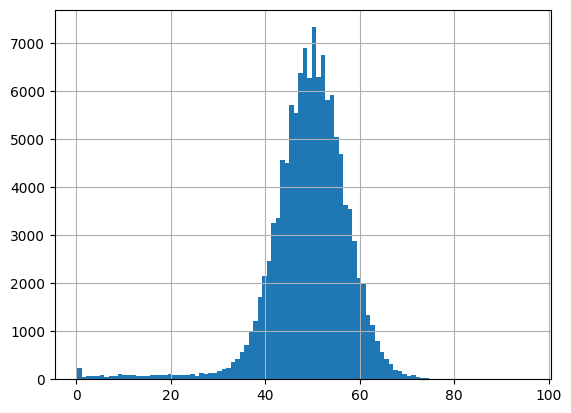

In [22]:
# рассмотрим распределение длин фанфиков на трейновой выборке
train['text'].apply(lambda x: len(x)).hist(bins=100)

In [ ]:
# выберем в качестве максимальной длины 70
MAX_LEN = 70

In [ ]:
# словарь для преобразования токенов в индексы
token_to_id = {k:i for i, k in enumerate(tokens)}

In [40]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

# ниже функции с семинара

# преобразование батча из текстов в батч из индескв
def as_matrix(sequences, max_len=MAX_LEN):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["transformed_text"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=MAX_LEN, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["transformed_text"] = as_matrix(data["transformed_text"].values, max_len)

    if word_dropout != 0:
        batch["transformed_text"] = apply_word_dropout(batch["transformed_text"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

# итерирование по батчам
def iterate_minibatches(data, batch_size=10, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch

        if not cycle: break

In [41]:
# функция для вывода промежуточных результатов эпох
def print_metrics(model, data, criterion, batch_size=10, sample_type='Val', device=torch.device('cpu')):
    f1_macro = num_samples = 0.0

    pred = []
    true = []

    model.eval()

    overall_loss = 0
    steps = 0

    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device):
            batch_score = model(batch)
            batch_pred = batch_score.argmax(dim=1)

            pred.extend(batch_pred.detach().cpu())
            true.extend(batch[TARGET_COLUMN].detach().cpu())

            loss = criterion(batch_score, batch[TARGET_COLUMN])
            overall_loss += loss.item()
            steps += 1

    avg_loss = overall_loss / steps
    f1_macro = f1_score(true, pred, average='macro')

    print(sample_type + " Avg Loss: %.5f" % avg_loss)
    print(sample_type + " F1-macro: %.5f" % f1_macro)

    return pred

### 2. Используйте сверточные сети в качестве более продвинутого классификатора. Поэкспериментируйте с количеством и размерностью фильтров, используйте разные размеры окон, попробуйте использовать  𝑘 -max pooling.

In [46]:
# модель с 1-й сверткой без k-max pooling
class ConvPredictor_1(nn.Module):
    def __init__(self, n_tokens=len(tokens), num_classes=len(spell_dct), hidden_size=128, kernel_size=5):
        super().__init__()
        self.emb = nn.Embedding(n_tokens, hidden_size)

        self.conv1 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding='same')
        self.relu1 = nn.ReLU()

        self.out = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.emb(x['transformed_text'])
        x = x.transpose(1, 2)

        x = self.conv1(x)
        x = self.relu1(x)
        x = F.max_pool1d(x, x.shape[2]).squeeze(-1)

        x = self.out(x)

        return x

# модель с 1-й сверткой c k-max pooling
class ConvPredictor_2(nn.Module):
    def __init__(self, n_tokens=len(tokens), num_classes=len(spell_dct), hidden_size=128, kernel_size=5, top_k=5):
        super().__init__()
        self.top_k = top_k

        self.emb = nn.Embedding(n_tokens, hidden_size)

        self.conv1 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding='same')
        self.relu1 = nn.ReLU()

        self.out = nn.Sequential(
            nn.Linear(top_k * hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        x = self.emb(x['transformed_text'])
        x = x.transpose(1, 2)

        x = self.conv1(x)
        x = self.relu1(x)

        x, _ = torch.topk(x, self.top_k, dim=-1)
        x = torch.flatten(x, start_dim=1)

        x = self.out(x)

        return x

# модель с 2-мя свертками без k-max pooling
class ConvPredictor_3(nn.Module):
    def __init__(self, n_tokens=len(tokens), num_classes=len(spell_dct), hidden_size=128, kernel_size=[5,3]):
        super().__init__()
        self.emb = nn.Embedding(n_tokens, hidden_size)

        self.conv1 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size[0], padding='same')
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size[1], padding='same')
        self.relu2 = nn.ReLU()

        self.out = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.emb(x['transformed_text'])
        x = x.transpose(1, 2)

        x = self.conv1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.relu2(x)

        x = F.max_pool1d(x, x.shape[2]).squeeze(-1)

        x = self.out(x)

        return x

# модель с 3-мя свертками без k-max pooling
class ConvPredictor_4(nn.Module):
    def __init__(self, n_tokens=len(tokens), num_classes=len(spell_dct), hidden_size=128, kernel_size=[7,5,3]):
        super().__init__()

        self.emb = nn.Embedding(n_tokens, hidden_size)

        self.conv1 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size[0], padding='same')
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size[1], padding='same')
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size[2], padding='same')
        self.relu3 = nn.ReLU()

        self.out = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.emb(x['transformed_text'])
        x = x.transpose(1, 2)

        x = self.conv1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = F.max_pool1d(x, x.shape[2]).squeeze(-1)

        x = self.out(x)

        return x

Все модели будем обучать на 10 эпохах с размером батча = 16

* Рассматриваемые параметры для kernel_size: 3, 5
* Рассматриваемые параметры для hidden_size: 64, 128
* Рассматриваемые параметры для k (из k-max-pooling): 4, 5

In [ ]:
BATCH_SIZE = 16
EPOCHS = 10

hidden_sizes = [64, 128]
kernel_sizes = [3, 5]
k_sizes = [4, 5]

models_dct = {}

In [ ]:
# модель с 1-й сверткой без k-max pooling
for hidden_size in hidden_sizes:
    for kernel_size in kernel_sizes:
        print('hidden_size = ', hidden_size, 'kernel_size = ', kernel_size)

        model = ConvPredictor_1(hidden_size=hidden_size, kernel_size=kernel_size).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

        for epoch in range(EPOCHS):
            print(f"epoch: {epoch}")
            model.train()
            overall_loss = 0
            steps = 0

            for i, batch in tqdm(enumerate(
                    iterate_minibatches(train, batch_size=BATCH_SIZE, device=device)),
                    total=len(train) // BATCH_SIZE
                ):
                pred = model(batch)
                loss = criterion(pred, batch[TARGET_COLUMN])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                overall_loss += loss.item()
                steps += 1

            avg_loss = overall_loss / steps
            print('Train Avg Loss:  %.5f' % avg_loss)
            print_metrics(model, dev, criterion=criterion, device=device)

        models_dct[(hidden_size, kernel_size)] = model

hidden_size =  64 kernel_size =  3
epoch: 0


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.39057
Val Avg Loss: 3.38944
Val F1-macro: 0.03308
epoch: 1


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.21546
Val Avg Loss: 3.23668
Val F1-macro: 0.03891
epoch: 2


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.11533
Val Avg Loss: 3.17195
Val F1-macro: 0.04400
epoch: 3


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.04717
Val Avg Loss: 3.11722
Val F1-macro: 0.05003
epoch: 4


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.99958
Val Avg Loss: 3.14500
Val F1-macro: 0.05082
epoch: 5


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.95592
Val Avg Loss: 3.10081
Val F1-macro: 0.05970
epoch: 6


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.91569
Val Avg Loss: 3.09505
Val F1-macro: 0.06155
epoch: 7


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.88815
Val Avg Loss: 3.10141
Val F1-macro: 0.06001
epoch: 8


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.86170
Val Avg Loss: 3.10583
Val F1-macro: 0.06060
epoch: 9


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.83823
Val Avg Loss: 3.10072
Val F1-macro: 0.05935
hidden_size =  64 kernel_size =  5
epoch: 0


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.46440
Val Avg Loss: 3.29875
Val F1-macro: 0.02918
epoch: 1


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.29625
Val Avg Loss: 3.30269
Val F1-macro: 0.03184
epoch: 2


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.18145
Val Avg Loss: 3.26892
Val F1-macro: 0.03660
epoch: 3


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.10184
Val Avg Loss: 3.21843
Val F1-macro: 0.04161
epoch: 4


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.03823
Val Avg Loss: 3.17607
Val F1-macro: 0.04681
epoch: 5


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.98818
Val Avg Loss: 3.16225
Val F1-macro: 0.04346
epoch: 6


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.94366
Val Avg Loss: 3.16960
Val F1-macro: 0.04764
epoch: 7


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.89997
Val Avg Loss: 3.17696
Val F1-macro: 0.05227
epoch: 8


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.86796
Val Avg Loss: 3.17983
Val F1-macro: 0.05660
epoch: 9


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.83579
Val Avg Loss: 3.19918
Val F1-macro: 0.05597
hidden_size =  128 kernel_size =  3
epoch: 0


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.49138
Val Avg Loss: 3.44341
Val F1-macro: 0.03622
epoch: 1


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.26204
Val Avg Loss: 3.21472
Val F1-macro: 0.04851
epoch: 2


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.12962
Val Avg Loss: 3.18820
Val F1-macro: 0.04791
epoch: 3


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.02873
Val Avg Loss: 3.21390
Val F1-macro: 0.05640
epoch: 4


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.94353
Val Avg Loss: 3.19871
Val F1-macro: 0.05286
epoch: 5


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.87398
Val Avg Loss: 3.17308
Val F1-macro: 0.06125
epoch: 6


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.80672
Val Avg Loss: 3.21296
Val F1-macro: 0.06951
epoch: 7


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.74437
Val Avg Loss: 3.21684
Val F1-macro: 0.06450
epoch: 8


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.68857
Val Avg Loss: 3.26526
Val F1-macro: 0.07134
epoch: 9


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.62553
Val Avg Loss: 3.37260
Val F1-macro: 0.07011
hidden_size =  128 kernel_size =  5
epoch: 0


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.66077
Val Avg Loss: 3.37861
Val F1-macro: 0.03424
epoch: 1


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.39966
Val Avg Loss: 3.41589
Val F1-macro: 0.03726
epoch: 2


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.23429
Val Avg Loss: 3.28842
Val F1-macro: 0.04392
epoch: 3


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.12025
Val Avg Loss: 3.29535
Val F1-macro: 0.04821
epoch: 4


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.00298
Val Avg Loss: 3.37471
Val F1-macro: 0.05550
epoch: 5


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.90244
Val Avg Loss: 3.35286
Val F1-macro: 0.06213
epoch: 6


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.79365
Val Avg Loss: 3.53896
Val F1-macro: 0.05615
epoch: 7


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.69618
Val Avg Loss: 3.56473
Val F1-macro: 0.06235
epoch: 8


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.60945
Val Avg Loss: 3.64328
Val F1-macro: 0.06136
epoch: 9


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.50733
Val Avg Loss: 3.78928
Val F1-macro: 0.06200


In [ ]:
# модель с 1-й сверткой с k-max pooling
for hidden_size in hidden_sizes:
    for kernel_size in kernel_sizes:
        for top_k in k_sizes:
            print('hidden_size = ', hidden_size, 'kernel_size = ', kernel_size, 'top_k = ', top_k)

            model = ConvPredictor_2(hidden_size=hidden_size, kernel_size=kernel_size, top_k=top_k).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

            for epoch in range(EPOCHS):
                print(f"epoch: {epoch}")
                model.train()
                overall_loss = 0
                steps = 0

                for i, batch in tqdm(enumerate(
                        iterate_minibatches(train, batch_size=BATCH_SIZE, device=device)),
                        total=len(train) // BATCH_SIZE
                    ):
                    pred = model(batch)
                    loss = criterion(pred, batch[TARGET_COLUMN])
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    overall_loss += loss.item()
                    steps += 1

                avg_loss = overall_loss / steps
                print('Train Avg Loss:  %.5f' % avg_loss)
                print_metrics(model, dev, criterion=criterion, device=device)

            models_dct[(hidden_size, kernel_size, top_k)] = model

hidden_size =  64 kernel_size =  3 top_k =  4
epoch: 0


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.42673
Val Avg Loss: 3.39984
Val F1-macro: 0.00595
epoch: 1


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.29471
Val Avg Loss: 3.41964
Val F1-macro: 0.01133
epoch: 2


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.24818
Val Avg Loss: 3.35283
Val F1-macro: 0.01222
epoch: 3


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.20604
Val Avg Loss: 3.32018
Val F1-macro: 0.01478
epoch: 4


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.17081
Val Avg Loss: 3.27512
Val F1-macro: 0.02056
epoch: 5


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.13442
Val Avg Loss: 3.30140
Val F1-macro: 0.02270
epoch: 6


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.10308
Val Avg Loss: 3.32001
Val F1-macro: 0.02509
epoch: 7


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.06432
Val Avg Loss: 3.15071
Val F1-macro: 0.03788
epoch: 8


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.03131
Val Avg Loss: 3.25007
Val F1-macro: 0.03296
epoch: 9


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.00077
Val Avg Loss: 3.28761
Val F1-macro: 0.03499
hidden_size =  64 kernel_size =  3 top_k =  5
epoch: 0


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.43778
Val Avg Loss: 3.31556
Val F1-macro: 0.00915
epoch: 1


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.29804
Val Avg Loss: 3.53265
Val F1-macro: 0.00877
epoch: 2


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.23364
Val Avg Loss: 3.28583
Val F1-macro: 0.01850
epoch: 3


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.17862
Val Avg Loss: 3.22806
Val F1-macro: 0.02648
epoch: 4


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.13068
Val Avg Loss: 3.25270
Val F1-macro: 0.03334
epoch: 5


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.09197
Val Avg Loss: 3.19275
Val F1-macro: 0.03776
epoch: 6


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.05565
Val Avg Loss: 3.20571
Val F1-macro: 0.03259
epoch: 7


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.02603
Val Avg Loss: 3.13576
Val F1-macro: 0.04033
epoch: 8


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.99305
Val Avg Loss: 3.13772
Val F1-macro: 0.04092
epoch: 9


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  2.96363
Val Avg Loss: 3.16154
Val F1-macro: 0.03888
hidden_size =  64 kernel_size =  5 top_k =  4
epoch: 0


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.45194
Val Avg Loss: 3.66899
Val F1-macro: 0.00501
epoch: 1


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.35881
Val Avg Loss: 3.32679
Val F1-macro: 0.00947
epoch: 2


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.32610
Val Avg Loss: 3.38894
Val F1-macro: 0.00672
epoch: 3


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.29332
Val Avg Loss: 3.35591
Val F1-macro: 0.00913
epoch: 4


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.26167
Val Avg Loss: 3.43982
Val F1-macro: 0.00992
epoch: 5


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.22578
Val Avg Loss: 3.62212
Val F1-macro: 0.01294
epoch: 6


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.19018
Val Avg Loss: 3.32493
Val F1-macro: 0.01788
epoch: 7


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.16005
Val Avg Loss: 3.32675
Val F1-macro: 0.01998
epoch: 8


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.12727
Val Avg Loss: 3.33212
Val F1-macro: 0.02197
epoch: 9


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.09998
Val Avg Loss: 3.31478
Val F1-macro: 0.02161
hidden_size =  64 kernel_size =  5 top_k =  5
epoch: 0


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.44328
Val Avg Loss: 3.40427
Val F1-macro: 0.00534
epoch: 1


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.33890
Val Avg Loss: 3.31637
Val F1-macro: 0.00864
epoch: 2


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.29306
Val Avg Loss: 3.30009
Val F1-macro: 0.00851
epoch: 3


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.25068
Val Avg Loss: 3.38424
Val F1-macro: 0.01075
epoch: 4


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.22872
Val Avg Loss: 3.29285
Val F1-macro: 0.01504
epoch: 5


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.18207
Val Avg Loss: 3.33258
Val F1-macro: 0.02170
epoch: 6


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.14428
Val Avg Loss: 3.29301
Val F1-macro: 0.02085
epoch: 7


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.11601
Val Avg Loss: 3.36196
Val F1-macro: 0.02324
epoch: 8


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.09079
Val Avg Loss: 3.26990
Val F1-macro: 0.02595
epoch: 9


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.06162
Val Avg Loss: 3.33190
Val F1-macro: 0.02998
hidden_size =  128 kernel_size =  3 top_k =  4
epoch: 0


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.47146
Val Avg Loss: 3.50738
Val F1-macro: 0.00867
epoch: 1


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.32425
Val Avg Loss: 3.32771
Val F1-macro: 0.01354
epoch: 2


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.31341
Val Avg Loss: 3.38046
Val F1-macro: 0.00791
epoch: 3


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.27135
Val Avg Loss: 3.30345
Val F1-macro: 0.01589
epoch: 4


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.29918
Val Avg Loss: 3.36585
Val F1-macro: 0.01212
epoch: 5


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.23767
Val Avg Loss: 3.38491
Val F1-macro: 0.01208
epoch: 6


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.22432
Val Avg Loss: 3.35888
Val F1-macro: 0.01092
epoch: 7


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.23086
Val Avg Loss: 3.59346
Val F1-macro: 0.01010
epoch: 8


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.19824
Val Avg Loss: 3.30938
Val F1-macro: 0.01901
epoch: 9


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.17477
Val Avg Loss: 3.55293
Val F1-macro: 0.01462
hidden_size =  128 kernel_size =  3 top_k =  5
epoch: 0


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.53655
Val Avg Loss: 3.53205
Val F1-macro: 0.00287
epoch: 1


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.40070
Val Avg Loss: 3.38686
Val F1-macro: 0.00610
epoch: 2


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.36116
Val Avg Loss: 3.36916
Val F1-macro: 0.00590
epoch: 3


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.34327
Val Avg Loss: 3.38373
Val F1-macro: 0.00837
epoch: 4


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.28962
Val Avg Loss: 3.32377
Val F1-macro: 0.00988
epoch: 5


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.27026
Val Avg Loss: 3.30722
Val F1-macro: 0.01459
epoch: 6


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.24771
Val Avg Loss: 3.31349
Val F1-macro: 0.01249
epoch: 7


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.24432
Val Avg Loss: 3.37026
Val F1-macro: 0.01024
epoch: 8


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.23261
Val Avg Loss: 3.40442
Val F1-macro: 0.01115
epoch: 9


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.23571
Val Avg Loss: 3.37210
Val F1-macro: 0.00856
hidden_size =  128 kernel_size =  5 top_k =  4
epoch: 0


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.53135
Val Avg Loss: 3.39112
Val F1-macro: 0.00523
epoch: 1


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.39974
Val Avg Loss: 3.38204
Val F1-macro: 0.01256
epoch: 2


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.38138
Val Avg Loss: 3.48042
Val F1-macro: 0.00527
epoch: 3


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.41846
Val Avg Loss: 3.47336
Val F1-macro: 0.00275
epoch: 4


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.40605
Val Avg Loss: 3.44758
Val F1-macro: 0.00574
epoch: 5


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.39259
Val Avg Loss: 3.47282
Val F1-macro: 0.00266
epoch: 6


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.35286
Val Avg Loss: 3.39493
Val F1-macro: 0.00604
epoch: 7


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.34151
Val Avg Loss: 3.56324
Val F1-macro: 0.00812
epoch: 8


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.32431
Val Avg Loss: 3.34917
Val F1-macro: 0.00957
epoch: 9


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.31005
Val Avg Loss: 3.39266
Val F1-macro: 0.01001
hidden_size =  128 kernel_size =  5 top_k =  5
epoch: 0


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.49128
Val Avg Loss: 3.36537
Val F1-macro: 0.00883
epoch: 1


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.38925
Val Avg Loss: 3.52444
Val F1-macro: 0.00585
epoch: 2


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.35960
Val Avg Loss: 3.42377
Val F1-macro: 0.00863
epoch: 3


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.32926
Val Avg Loss: 3.44312
Val F1-macro: 0.00751
epoch: 4


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.31658
Val Avg Loss: 3.33484
Val F1-macro: 0.01368
epoch: 5


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.27079
Val Avg Loss: 3.32556
Val F1-macro: 0.00925
epoch: 6


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.25010
Val Avg Loss: 3.44272
Val F1-macro: 0.01267
epoch: 7


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.23460
Val Avg Loss: 3.55513
Val F1-macro: 0.00754
epoch: 8


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.20550
Val Avg Loss: 3.39419
Val F1-macro: 0.01203
epoch: 9


  0%|          | 0/2419 [00:00<?, ?it/s]

Train Avg Loss:  3.19372
Val Avg Loss: 3.42324
Val F1-macro: 0.01224


Из экспериментов с 1-й сверткой можно сделать следующие выводы:

* если использовать max-pooling, то увеличение размера фильтра (hidden_dim) улучшает качество (при этом начинает прослеживатсья переобучение), а размер окна (kernel_size) нет;

* если использовать k-max-pooling, то увеличение k улучшает качество, увеличение размера фильтра и размера окна не дает существенных улучшений;

* max-pooling дает качество лучше, чем k-max pooling.

Учитывая последний вывод, далее поэкспериментируем с разным количеством сверточных слоев, но используя только max-pooling.

Протестируем модели с 2-мя и 3-мя фильтрами.

* Рассматриваемые параметры для kernel_size: [5,3], [3,3], [5,5,3], [5, 3, 3]
* Рассматриваемые параметры для hidden_size: 128, 256

In [ ]:
BATCH_SIZE = 16
EPOCHS = 10

hidden_sizes = [128, 256]
kernel_sizes = [(5, 3), (3, 3)]

In [ ]:
# модель с 2-мя сверткой без k-max pooling
for hidden_size in hidden_sizes:
    for kernel_size in kernel_sizes:
        print('hidden_size = ', hidden_size, 'kernel_size = ', kernel_size)

        model = ConvPredictor_3(hidden_size=hidden_size, kernel_size=kernel_size).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

        for epoch in range(EPOCHS):
            print(f"epoch: {epoch}")
            model.train()
            overall_loss = 0
            steps = 0

            for i, batch in tqdm(enumerate(
                    iterate_minibatches(train, batch_size=BATCH_SIZE, device=device)),
                    total=len(train) // BATCH_SIZE
                ):
                pred = model(batch)
                loss = criterion(pred, batch[TARGET_COLUMN])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                overall_loss += loss.item()
                steps += 1

            avg_loss = overall_loss / steps
            print('Train Avg Loss:  %.5f' % avg_loss)
            print_metrics(model, dev, criterion=criterion, device=device)

        models_dct[(hidden_size, kernel_size)] = model

hidden_size =  128 kernel_size =  (5, 3)
epoch: 0


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.24575
Val Avg Loss: 3.25651
Val F1-macro: 0.03409
epoch: 1


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.04656
Val Avg Loss: 3.15008
Val F1-macro: 0.04535
epoch: 2


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.95157
Val Avg Loss: 3.13466
Val F1-macro: 0.05082
epoch: 3


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.87283
Val Avg Loss: 3.18899
Val F1-macro: 0.05625
epoch: 4


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.80379
Val Avg Loss: 3.33870
Val F1-macro: 0.05032
epoch: 5


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.73815
Val Avg Loss: 3.20111
Val F1-macro: 0.05771
epoch: 6


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.66981
Val Avg Loss: 3.27462
Val F1-macro: 0.05519
epoch: 7


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.60872
Val Avg Loss: 3.33925
Val F1-macro: 0.05656
epoch: 8


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.55061
Val Avg Loss: 3.41578
Val F1-macro: 0.05711
epoch: 9


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.49842
Val Avg Loss: 3.46461
Val F1-macro: 0.05471
hidden_size =  128 kernel_size =  (3, 3)
epoch: 0


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.22613
Val Avg Loss: 3.18221
Val F1-macro: 0.03898
epoch: 1


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.00868
Val Avg Loss: 3.09902
Val F1-macro: 0.04763
epoch: 2


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.92060
Val Avg Loss: 3.09134
Val F1-macro: 0.05483
epoch: 3


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.85003
Val Avg Loss: 3.07415
Val F1-macro: 0.06024
epoch: 4


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.79084
Val Avg Loss: 3.16274
Val F1-macro: 0.05746
epoch: 5


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.73109
Val Avg Loss: 3.18837
Val F1-macro: 0.05583
epoch: 6


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.67998
Val Avg Loss: 3.18017
Val F1-macro: 0.06602
epoch: 7


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.62374
Val Avg Loss: 3.25602
Val F1-macro: 0.06044
epoch: 8


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.57549
Val Avg Loss: 3.31840
Val F1-macro: 0.06467
epoch: 9


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.52651
Val Avg Loss: 3.33758
Val F1-macro: 0.06674
hidden_size =  256 kernel_size =  (5, 3)
epoch: 0


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.19681
Val Avg Loss: 3.18263
Val F1-macro: 0.03922
epoch: 1


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.97486
Val Avg Loss: 3.09036
Val F1-macro: 0.05221
epoch: 2


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.83428
Val Avg Loss: 3.10809
Val F1-macro: 0.05583
epoch: 3


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.70881
Val Avg Loss: 3.20228
Val F1-macro: 0.05949
epoch: 4


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.57085
Val Avg Loss: 3.38225
Val F1-macro: 0.05437
epoch: 5


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.44243
Val Avg Loss: 3.44718
Val F1-macro: 0.06004
epoch: 6


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.31841
Val Avg Loss: 3.53480
Val F1-macro: 0.06287
epoch: 7


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.19968
Val Avg Loss: 3.72047
Val F1-macro: 0.06691
epoch: 8


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.08834
Val Avg Loss: 4.45294
Val F1-macro: 0.06293
epoch: 9


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  1.99358
Val Avg Loss: 4.14488
Val F1-macro: 0.06010
hidden_size =  256 kernel_size =  (3, 3)
epoch: 0


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.15258
Val Avg Loss: 3.14085
Val F1-macro: 0.05221
epoch: 1


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.92369
Val Avg Loss: 3.06178
Val F1-macro: 0.05643
epoch: 2


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.79987
Val Avg Loss: 3.06880
Val F1-macro: 0.06429
epoch: 3


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.68789
Val Avg Loss: 3.07552
Val F1-macro: 0.06908
epoch: 4


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.58928
Val Avg Loss: 3.15650
Val F1-macro: 0.07169
epoch: 5


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.48417
Val Avg Loss: 3.29916
Val F1-macro: 0.07010
epoch: 6


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.38142
Val Avg Loss: 3.32696
Val F1-macro: 0.07684
epoch: 7


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.28875
Val Avg Loss: 3.44468
Val F1-macro: 0.07535
epoch: 8


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.19941
Val Avg Loss: 3.61009
Val F1-macro: 0.07830
epoch: 9


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.10838
Val Avg Loss: 3.80517
Val F1-macro: 0.07720


Для классификатора с двумя свертками:

* использование размеров фильтров [3,3] показало качество лучше, чем [5,3]
* увеличение количества фильтрво увеличило качество
* уже наблюдается переобучение (увеличивается лосс на валидации, хотя качество не всегда падает)

In [ ]:
kernel_sizes = [(5, 5, 3), (5, 3, 3)]

In [ ]:
# модель с 3-мя сверткой без k-max pooling
for hidden_size in hidden_sizes:
    for kernel_size in kernel_sizes:
        print('hidden_size = ', hidden_size, 'kernel_size = ', kernel_size)

        model = ConvPredictor_4(hidden_size=hidden_size, kernel_size=kernel_size).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

        for epoch in range(EPOCHS):
            print(f"epoch: {epoch}")
            model.train()
            overall_loss = 0
            steps = 0

            for i, batch in tqdm(enumerate(
                    iterate_minibatches(train, batch_size=BATCH_SIZE, device=device)),
                    total=len(train) // BATCH_SIZE
                ):
                pred = model(batch)
                loss = criterion(pred, batch[TARGET_COLUMN])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                overall_loss += loss.item()
                steps += 1

            avg_loss = overall_loss / steps
            print('Train Avg Loss:  %.5f' % avg_loss)
            print_metrics(model, dev, criterion=criterion, device=device)

        models_dct[(hidden_size, kernel_size)] = model

hidden_size =  128 kernel_size =  (5, 5, 3)
epoch: 0


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.30231
Val Avg Loss: 3.23277
Val F1-macro: 0.02374
epoch: 1


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.09351
Val Avg Loss: 3.20515
Val F1-macro: 0.03092
epoch: 2


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.97590
Val Avg Loss: 3.11566
Val F1-macro: 0.03751
epoch: 3


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.88479
Val Avg Loss: 3.11471
Val F1-macro: 0.04986
epoch: 4


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.80464
Val Avg Loss: 3.13543
Val F1-macro: 0.05284
epoch: 5


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.73438
Val Avg Loss: 3.22578
Val F1-macro: 0.05431
epoch: 6


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.66716
Val Avg Loss: 3.20520
Val F1-macro: 0.05352
epoch: 7


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.60077
Val Avg Loss: 3.27564
Val F1-macro: 0.05369
epoch: 8


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.54172
Val Avg Loss: 3.30890
Val F1-macro: 0.05952
epoch: 9


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.48360
Val Avg Loss: 3.48593
Val F1-macro: 0.05648
hidden_size =  128 kernel_size =  (5, 3, 3)
epoch: 0


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.32628
Val Avg Loss: 3.45376
Val F1-macro: 0.01146
epoch: 1


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.12119
Val Avg Loss: 3.11842
Val F1-macro: 0.03372
epoch: 2


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.99266
Val Avg Loss: 3.12825
Val F1-macro: 0.04354
epoch: 3


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.89516
Val Avg Loss: 3.11865
Val F1-macro: 0.04351
epoch: 4


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.82488
Val Avg Loss: 3.10533
Val F1-macro: 0.05690
epoch: 5


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.75904
Val Avg Loss: 3.17342
Val F1-macro: 0.04927
epoch: 6


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.70368
Val Avg Loss: 3.19971
Val F1-macro: 0.05999
epoch: 7


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.64832
Val Avg Loss: 3.22196
Val F1-macro: 0.05884
epoch: 8


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.58668
Val Avg Loss: 3.26672
Val F1-macro: 0.05585
epoch: 9


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.53285
Val Avg Loss: 3.29998
Val F1-macro: 0.06198
hidden_size =  256 kernel_size =  (5, 5, 3)
epoch: 0


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.27066
Val Avg Loss: 3.19595
Val F1-macro: 0.02893
epoch: 1


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.01583
Val Avg Loss: 3.11481
Val F1-macro: 0.03755
epoch: 2


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.86255
Val Avg Loss: 3.06458
Val F1-macro: 0.05227
epoch: 3


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.72198
Val Avg Loss: 3.12228
Val F1-macro: 0.06110
epoch: 4


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.59815
Val Avg Loss: 3.13725
Val F1-macro: 0.05647
epoch: 5


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.48156
Val Avg Loss: 3.65527
Val F1-macro: 0.05116
epoch: 6


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.37257
Val Avg Loss: 3.29901
Val F1-macro: 0.06354
epoch: 7


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.26163
Val Avg Loss: 3.41515
Val F1-macro: 0.06304
epoch: 8


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.16053
Val Avg Loss: 3.58578
Val F1-macro: 0.06452
epoch: 9


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.08619
Val Avg Loss: 3.68654
Val F1-macro: 0.06782
hidden_size =  256 kernel_size =  (5, 3, 3)
epoch: 0


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.28400
Val Avg Loss: 3.21384
Val F1-macro: 0.02561
epoch: 1


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.03057
Val Avg Loss: 3.05605
Val F1-macro: 0.03986
epoch: 2


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.86071
Val Avg Loss: 3.22332
Val F1-macro: 0.04903
epoch: 3


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.73318
Val Avg Loss: 3.06876
Val F1-macro: 0.06163
epoch: 4


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.61935
Val Avg Loss: 3.15088
Val F1-macro: 0.05985
epoch: 5


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.50416
Val Avg Loss: 3.25579
Val F1-macro: 0.06314
epoch: 6


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.40267
Val Avg Loss: 3.28498
Val F1-macro: 0.06329
epoch: 7


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.30630
Val Avg Loss: 3.40819
Val F1-macro: 0.06089
epoch: 8


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.20895
Val Avg Loss: 3.66671
Val F1-macro: 0.06048
epoch: 9


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.14173
Val Avg Loss: 3.64952
Val F1-macro: 0.06681


Для классификатора с тремя свертками:

* меньшие размеры фильтров так же лучше
* увеличение количества фильтрво так же увеличивает качество
* так же прослеживается переобучение, но не такое сильное

Возьмем модель с 2-мя свертками, размеры окон у которых по 3 и количество фильтров 256. Замерим качество на тесте.

In [ ]:
# результаты на тесте
pred = print_metrics(models_dct[256, (3,3)], test, criterion=criterion, device=device, sample_type='Test');

Test Avg Loss: 3.81175
Test F1-macro: 0.08177


Ура! Качество больше, чем в бейзлайне fasttext.

In [ ]:
# рассмотрим результат
print(classification_report(test[TARGET_COLUMN].values, pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.75      0.47      0.58        83
           1       0.13      0.18      0.15       423
           2       0.16      0.32      0.21       516
           3       0.15      0.08      0.10       335
           4       0.10      0.07      0.09       205
           5       0.28      0.30      0.29       501
           6       0.29      0.47      0.36       909
           7       0.08      0.06      0.07       147
           8       0.32      0.39      0.35       915
           9       0.17      0.11      0.14       145
          10       0.23      0.19      0.21       157
          11       0.03      0.01      0.01       117
          12       0.13      0.10      0.11       164
          13       0.00      0.00      0.00         2
          14       0.22      0.09      0.12       138
          15       0.06      0.04      0.04        53
          16       0.29      0.41      0.34       164
          17       0.57    

In [ ]:
cm = confusion_matrix(test[TARGET_COLUMN].values, pred)

plt.figure(figsize = (100,100))
sn.heatmap(cm, annot=True)
plt.show()

В целом, ситуация очень схожа с fasttext. Малые классы так же плохо предсказываются, а схожие заклинания (упомянутые в выводе после fasttext) путаются.

### 3. Используйте рекуррентные сети в качестве альтернативного продвинутого классификатора. Поэкспериментируйте с количеством и размерностью слоев и другими гиперпараметрами.

In [31]:
# основа взята с https://www.kaggle.com/code/mehmetlaudatekman/lstm-text-classification-pytorch
class RNNPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=num_layers,
                            dropout=dropout,
                            batch_first=True
                           )

        self.linear = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x['transformed_text'])

        x, _ = self.lstm(x)

        x = x[:,-1,:]

        x = self.linear(x)

        return x

Будем использовать LSTM в качестве RNN. Рассмотрим параметры для количества слоев - 1 и 2, размеронсть - 64 и 128, а также гиперпараметр dropout - 0 и 0.2.

In [ ]:
BATCH_SIZE = 16
EPOCHS = 10

num_layers_list = [1, 2]
hidden_dims = [64, 128]
dropouts = [0, 0.2]

models_dct = {}

In [ ]:
for hidden_dim in hidden_dims:
    for num_layers in num_layers_list:
        for dropout in dropouts:
            print('hidden_size = ', hidden_dim, 'n_layers = ', num_layers, 'dropout = ', dropout)

            model = RNNPredictor(vocab_size=len(tokens), embedding_dim=hidden_dim, hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout, num_classes=len(spell_dct)).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

            for epoch in range(EPOCHS):
                print(f"epoch: {epoch}")
                model.train()
                overall_loss = 0
                steps = 0

                for i, batch in tqdm(enumerate(
                        iterate_minibatches(train, batch_size=BATCH_SIZE, device=device)),
                        total=len(train) // BATCH_SIZE
                    ):
                    pred = model(batch)
                    loss = criterion(pred, batch[TARGET_COLUMN])
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    overall_loss += loss.item()
                    steps += 1

                avg_loss = overall_loss / steps
                print('Train Avg Loss:  %.5f' % avg_loss)
                print_metrics(model, dev, criterion=criterion, device=device)

            models_dct[(hidden_size, kernel_size)] = model

hidden_size =  64 n_layers =  1 dropout =  0
epoch: 0


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.46487
Val Avg Loss: 3.41859
Val F1-macro: 0.00740
epoch: 1


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.32448
Val Avg Loss: 3.30911
Val F1-macro: 0.00980
epoch: 2


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.22593
Val Avg Loss: 3.25008
Val F1-macro: 0.01721
epoch: 3


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.17052
Val Avg Loss: 3.21366
Val F1-macro: 0.01892
epoch: 4


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.11889
Val Avg Loss: 3.16265
Val F1-macro: 0.02591
epoch: 5


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.05502
Val Avg Loss: 3.10746
Val F1-macro: 0.03167
epoch: 6


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.99303
Val Avg Loss: 3.05473
Val F1-macro: 0.03601
epoch: 7


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.93913
Val Avg Loss: 3.11933
Val F1-macro: 0.03452
epoch: 8


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.89073
Val Avg Loss: 3.01899
Val F1-macro: 0.04633
epoch: 9


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.84332
Val Avg Loss: 3.00702
Val F1-macro: 0.04922
hidden_size =  64 n_layers =  1 dropout =  0.2
epoch: 0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.47320
Val Avg Loss: 3.46839
Val F1-macro: 0.00444
epoch: 1


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.39443
Val Avg Loss: 3.34392
Val F1-macro: 0.00628
epoch: 2


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.27567
Val Avg Loss: 3.27381
Val F1-macro: 0.01204
epoch: 3


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.18325
Val Avg Loss: 3.18852
Val F1-macro: 0.02495
epoch: 4


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.09587
Val Avg Loss: 3.11527
Val F1-macro: 0.03149
epoch: 5


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.02233
Val Avg Loss: 3.06800
Val F1-macro: 0.03638
epoch: 6


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.96271
Val Avg Loss: 3.05275
Val F1-macro: 0.04318
epoch: 7


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.91207
Val Avg Loss: 3.00555
Val F1-macro: 0.04407
epoch: 8


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.86393
Val Avg Loss: 2.99819
Val F1-macro: 0.04562
epoch: 9


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.81694
Val Avg Loss: 2.98255
Val F1-macro: 0.05211
hidden_size =  64 n_layers =  2 dropout =  0
epoch: 0


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.47097
Val Avg Loss: 3.46920
Val F1-macro: 0.00262
epoch: 1


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.44023
Val Avg Loss: 3.44204
Val F1-macro: 0.00645
epoch: 2


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.34136
Val Avg Loss: 3.30994
Val F1-macro: 0.00900
epoch: 3


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.20590
Val Avg Loss: 3.21719
Val F1-macro: 0.01552
epoch: 4


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.10683
Val Avg Loss: 3.15457
Val F1-macro: 0.02390
epoch: 5


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.03577
Val Avg Loss: 3.08092
Val F1-macro: 0.02892
epoch: 6


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.97268
Val Avg Loss: 3.04004
Val F1-macro: 0.03412
epoch: 7


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.91330
Val Avg Loss: 3.00287
Val F1-macro: 0.03927
epoch: 8


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.85211
Val Avg Loss: 2.97572
Val F1-macro: 0.04201
epoch: 9


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.79748
Val Avg Loss: 2.98224
Val F1-macro: 0.05047
hidden_size =  64 n_layers =  2 dropout =  0.2
epoch: 0


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.47109
Val Avg Loss: 3.47186
Val F1-macro: 0.00441
epoch: 1


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.43728
Val Avg Loss: 3.45653
Val F1-macro: 0.00461
epoch: 2


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.32058
Val Avg Loss: 3.27826
Val F1-macro: 0.01139
epoch: 3


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.20352
Val Avg Loss: 3.19728
Val F1-macro: 0.01819
epoch: 4


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.12947
Val Avg Loss: 3.18185
Val F1-macro: 0.02041
epoch: 5


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.07557
Val Avg Loss: 3.11499
Val F1-macro: 0.02347
epoch: 6


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.01923
Val Avg Loss: 3.07532
Val F1-macro: 0.02746
epoch: 7


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.96383
Val Avg Loss: 3.06571
Val F1-macro: 0.03236
epoch: 8


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.90610
Val Avg Loss: 3.02067
Val F1-macro: 0.03403
epoch: 9


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.84904
Val Avg Loss: 2.99986
Val F1-macro: 0.04400
hidden_size =  128 n_layers =  1 dropout =  0
epoch: 0


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.44324
Val Avg Loss: 3.36453
Val F1-macro: 0.00735
epoch: 1


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.27004
Val Avg Loss: 3.24124
Val F1-macro: 0.01312
epoch: 2


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.15272
Val Avg Loss: 3.21690
Val F1-macro: 0.02247
epoch: 3


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.05606
Val Avg Loss: 3.08187
Val F1-macro: 0.03423
epoch: 4


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.96765
Val Avg Loss: 3.04163
Val F1-macro: 0.04302
epoch: 5


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.88526
Val Avg Loss: 2.98474
Val F1-macro: 0.04981
epoch: 6


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.80886
Val Avg Loss: 2.94807
Val F1-macro: 0.05589
epoch: 7


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.73701
Val Avg Loss: 2.95007
Val F1-macro: 0.05966
epoch: 8


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.66715
Val Avg Loss: 2.95360
Val F1-macro: 0.06044
epoch: 9


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.59757
Val Avg Loss: 2.98316
Val F1-macro: 0.06356
hidden_size =  128 n_layers =  1 dropout =  0.2
epoch: 0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.46080
Val Avg Loss: 3.41701
Val F1-macro: 0.00538
epoch: 1


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.25254
Val Avg Loss: 3.20252
Val F1-macro: 0.01589
epoch: 2


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.13455
Val Avg Loss: 3.14493
Val F1-macro: 0.02699
epoch: 3


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.06162
Val Avg Loss: 3.08318
Val F1-macro: 0.03272
epoch: 4


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.98263
Val Avg Loss: 3.02740
Val F1-macro: 0.04099
epoch: 5


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.90500
Val Avg Loss: 2.99053
Val F1-macro: 0.04763
epoch: 6


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.82478
Val Avg Loss: 2.94438
Val F1-macro: 0.05891
epoch: 7


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.74643
Val Avg Loss: 2.94252
Val F1-macro: 0.06215
epoch: 8


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.67370
Val Avg Loss: 2.92959
Val F1-macro: 0.06610
epoch: 9


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.60103
Val Avg Loss: 2.92984
Val F1-macro: 0.06781
hidden_size =  128 n_layers =  2 dropout =  0
epoch: 0


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.46883
Val Avg Loss: 3.48991
Val F1-macro: 0.00246
epoch: 1


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.43075
Val Avg Loss: 3.44772
Val F1-macro: 0.00688
epoch: 2


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.26425
Val Avg Loss: 3.23663
Val F1-macro: 0.01542
epoch: 3


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.13428
Val Avg Loss: 3.15876
Val F1-macro: 0.01810
epoch: 4


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.03881
Val Avg Loss: 3.09169
Val F1-macro: 0.02818
epoch: 5


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.94829
Val Avg Loss: 3.02973
Val F1-macro: 0.03563
epoch: 6


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.85507
Val Avg Loss: 2.99527
Val F1-macro: 0.04482
epoch: 7


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.77470
Val Avg Loss: 2.95041
Val F1-macro: 0.05244
epoch: 8


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.69982
Val Avg Loss: 2.97149
Val F1-macro: 0.05764
epoch: 9


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.62610
Val Avg Loss: 2.95066
Val F1-macro: 0.05831
hidden_size =  128 n_layers =  2 dropout =  0.2
epoch: 0


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.46652
Val Avg Loss: 3.47098
Val F1-macro: 0.00540
epoch: 1


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.31997
Val Avg Loss: 3.29065
Val F1-macro: 0.01357
epoch: 2


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.18307
Val Avg Loss: 3.20660
Val F1-macro: 0.01197
epoch: 3


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.07784
Val Avg Loss: 3.11132
Val F1-macro: 0.02676
epoch: 4


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.98570
Val Avg Loss: 3.05259
Val F1-macro: 0.04010
epoch: 5


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.90526
Val Avg Loss: 2.99742
Val F1-macro: 0.04432
epoch: 6


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.82929
Val Avg Loss: 2.97836
Val F1-macro: 0.04796
epoch: 7


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.76073
Val Avg Loss: 2.95759
Val F1-macro: 0.05335
epoch: 8


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.69183
Val Avg Loss: 2.94263
Val F1-macro: 0.05708
epoch: 9


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.62166
Val Avg Loss: 2.93261
Val F1-macro: 0.06123


В данном случае наилучшее качество показала модель с параметрами: hidden_size =  128, n_layers =  1, dropout =  0.2. Отмечу, что RNN гораздо лучше справляется с переобучением, чем CNN (что с dropout, что без него).

Обучим модель на большем количестве эпох для улучшения качества.

In [ ]:
BATCH_SIZE = 16
EPOCHS = 30

num_layers = 1
hidden_dim = 128
dropout = 0.2

In [ ]:
model = RNNPredictor(vocab_size=len(tokens), embedding_dim=hidden_dim, hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout, num_classes=len(spell_dct)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    overall_loss = 0
    steps = 0

    for i, batch in tqdm(enumerate(
            iterate_minibatches(train, batch_size=BATCH_SIZE, device=device)),
            total=len(train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        overall_loss += loss.item()
        steps += 1

    avg_loss = overall_loss / steps
    print('Train Avg Loss:  %.5f' % avg_loss)
    print_metrics(model, dev, criterion=criterion, device=device)

epoch: 0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.43190
Val Avg Loss: 3.37045
Val F1-macro: 0.00648
epoch: 1


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.24106
Val Avg Loss: 3.23304
Val F1-macro: 0.01812
epoch: 2


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.10408
Val Avg Loss: 3.12637
Val F1-macro: 0.03038
epoch: 3


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  3.00621
Val Avg Loss: 3.04328
Val F1-macro: 0.04127
epoch: 4


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.92735
Val Avg Loss: 2.99104
Val F1-macro: 0.04389
epoch: 5


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.85263
Val Avg Loss: 2.97532
Val F1-macro: 0.05104
epoch: 6


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.78381
Val Avg Loss: 2.94966
Val F1-macro: 0.05718
epoch: 7


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.71561
Val Avg Loss: 2.97233
Val F1-macro: 0.06184
epoch: 8


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.64334
Val Avg Loss: 2.95197
Val F1-macro: 0.06346
epoch: 9


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.57412
Val Avg Loss: 2.96825
Val F1-macro: 0.06630
epoch: 10


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.50253
Val Avg Loss: 2.98615
Val F1-macro: 0.06543
epoch: 11


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.42655
Val Avg Loss: 3.02122
Val F1-macro: 0.06704
epoch: 12


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.35056
Val Avg Loss: 3.04777
Val F1-macro: 0.07125
epoch: 13


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.27451
Val Avg Loss: 3.12754
Val F1-macro: 0.06870
epoch: 14


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.19592
Val Avg Loss: 3.19473
Val F1-macro: 0.07165
epoch: 15


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.12366
Val Avg Loss: 3.22025
Val F1-macro: 0.07158
epoch: 16


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  2.05503
Val Avg Loss: 3.27773
Val F1-macro: 0.07339
epoch: 17


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  1.98858
Val Avg Loss: 3.33862
Val F1-macro: 0.07112
epoch: 18


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  1.92365
Val Avg Loss: 3.41372
Val F1-macro: 0.07398
epoch: 19


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  1.87609
Val Avg Loss: 3.48211
Val F1-macro: 0.07745
epoch: 20


  0%|          | 0/3811 [00:00<?, ?it/s]

Train Avg Loss:  1.82550
Val Avg Loss: 3.52934
Val F1-macro: 0.07443
epoch: 21


  0%|          | 0/3811 [00:00<?, ?it/s]

KeyboardInterrupt: 

Остановил обучение чуть раньше, потому что уже начиналось переобучение.

In [ ]:
# результаты на тесте
pred = print_metrics(model, test, criterion=criterion, device=device, sample_type='Test');

Test Avg Loss: 3.60110
Test F1-macro: 0.07599


Качество больше, чем у фасттекста! Рассмотрим более подробный отчет.

In [ ]:
# рассмотрим результат
print(classification_report(test[TARGET_COLUMN].values, pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.66      0.46      0.54        83
           1       0.17      0.18      0.18       423
           2       0.19      0.27      0.22       516
           3       0.13      0.18      0.15       335
           4       0.09      0.08      0.09       205
           5       0.30      0.44      0.36       501
           6       0.34      0.49      0.40       909
           7       0.09      0.07      0.08       147
           8       0.38      0.38      0.38       915
           9       0.14      0.17      0.16       145
          10       0.18      0.22      0.20       157
          11       0.02      0.01      0.01       117
          12       0.10      0.13      0.12       164
          13       0.00      0.00      0.00         2
          14       0.12      0.04      0.06       138
          15       0.00      0.00      0.00        53
          16       0.30      0.35      0.33       164
          17       0.47    

In [ ]:
cm = confusion_matrix(test[TARGET_COLUMN].values, pred)

plt.figure(figsize = (100,100))
sn.heatmap(cm, annot=True)
plt.show()

Выводы схожи с фасттекстом и CNN.

### 4. Попробуйте расширить обучающее множество за счет аугментации данных. Если вам понадобится словарь синонимов, можно использовать WordNet.

In [ ]:
# пройдемся по всем текстам и с определенной вероятностью будем менять токены (кроме unk) на один из синонимов
prob = 0.5
augmented_rows = []

for _, row in train.iterrows():
    augmented_row = []

    for token in row['transformed_text']:
        if token != 'UNK':
            # с вероятностью prob меняем слово на синоним
            if np.random.uniform() <= prob:
                # собираем все синонимы
                synonyms = []
                for synset in wn.synsets(token):
                    for lemma in synset.lemmas():
                        synonyms.append(lemma.name())

                # если не пустой список
                if synonyms:
                    # берем случайный синоним из всех синонимов
                    random_synonym = np.random.choice(synonyms)
                    augmented_row.append(random_synonym)
                else:
                    augmented_row.append(token)
            else:
                augmented_row.append(token)
        else:
            augmented_row.append(token)

    new_row = {'spell_class': row['spell_class'],
               'text': row['text'],
               'transformed_text': augmented_row}

    augmented_rows.append(new_row)

In [ ]:
# обновим тренировочный датасет
new_train = pd.concat([train, pd.DataFrame(augmented_rows)]).reset_index(drop=True)

Подготовим все для обучения.

In [ ]:
# создадим каунтер с количеством токенов в обучающей выборке
token_counts = Counter()

for text in tqdm(new_train['transformed_text'].values):
  for token in text:
      token_counts[token] += 1

  0%|          | 0/121960 [00:00<?, ?it/s]

In [ ]:
# так же избавимся от слов с маленьким количеством
min_count = 10
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

In [ ]:
# добавим токены для неизвестных слов и для паддинга
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [28]:
# выберем в качестве максимальной длины 70
MAX_LEN = 70

In [ ]:
# преобразуем обучающую выборку
new_train["new_transformed_text"] = new_train["transformed_text"].apply(lambda x: transform_text(x))

In [61]:
new_train['transformed_text'] = new_train["new_transformed_text"]

In [62]:
# словарь для преобразования токенов в индексы
token_to_id = {k:i for i, k in enumerate(tokens)}
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

In [67]:
# заново преобразуем val и test уже с новым списком tokens
dev["transformed_text"] = dev["text"].apply(lambda x: transform_text(x))
test["transformed_text"] = test["text"].apply(lambda x: transform_text(x))

Обучим выбранную RNN из 3-го блока.

In [64]:
BATCH_SIZE = 16
EPOCHS = 30

num_layers = 1
hidden_dim = 128
dropout = 0.2

In [68]:
model = RNNPredictor(vocab_size=len(tokens), embedding_dim=hidden_dim, hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout, num_classes=len(spell_dct)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    overall_loss = 0
    steps = 0

    for i, batch in tqdm(enumerate(
            iterate_minibatches(new_train, batch_size=BATCH_SIZE, device=device)),
            total=len(new_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        overall_loss += loss.item()
        steps += 1

    avg_loss = overall_loss / steps
    print('Train Avg Loss:  %.5f' % avg_loss)
    print_metrics(model, dev, criterion=criterion, device=device)

epoch: 0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


  0%|          | 0/7622 [00:00<?, ?it/s]

Train Avg Loss:  3.45522
Val Avg Loss: 3.52267
Val F1-macro: 0.00272
epoch: 1


  0%|          | 0/7622 [00:00<?, ?it/s]

Train Avg Loss:  3.44142
Val Avg Loss: 3.52672
Val F1-macro: 0.00287
epoch: 2


  0%|          | 0/7622 [00:00<?, ?it/s]

Train Avg Loss:  3.43887
Val Avg Loss: 3.50880
Val F1-macro: 0.00271
epoch: 3


  0%|          | 0/7622 [00:00<?, ?it/s]

KeyboardInterrupt: 

Я не очень понял где ошибка, но почему-то аугментация мне поломала все качество. Возможно, я не очень хорошо сделал препроцессинг... или просто что-то упустил.

## Часть 4. Итоги

Напишите краткое резюме проделанной работы. Читали ли вы сами Гарри Поттера или фанфики о нем и помогло ли вам знание предметной области в выполнении домашнего задания?

В данной работе для анализа текстов с помощью методов NLP использовался корпус фанфиков Гарри Поттера. Я читал всего одну из частей, но смотрел всю серию фильмов, поэтому в какой-то степени помогло знание некоторых заклинаний при анализе качества класссификации.

**Поэтапно, что было сделано:**

1) сначала проведен эксплоративный анализ, в котором выводили некоторые интересные факты;

2) во второй части поработал с word2vec: было видно, что поиск синонимов работает не самым лучшим образом в виду использования помимо синонимов еще и антонимов в схожих контекстах

3) далее перешел к классификации. Было 3 модели: fasttext, CNN, RNN, а также CNN/RNN с аугментацией. Fasttext показал качество 0.07 f1-macro, CNN и RNN смогли побить это качество, хотя возникали некоторые проблемы с переобучением. В целом все эти три классификатора хорошо предсказывают частые классы и плохо редкие, а также путают схожие заклинания.

4) аугментацию данных попытался применить, но почему-то не смог получить должного профита в качестве. Возможно, где-то закралась ошибка.